In [1]:
import os, sys, mne, socket, time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nilearn import plotting
from itertools import product

from initialization import load_paths
from preprocFuncs import getRawData, getTrials, runTGA, runTGA_TMS
# from plotters import plotPower, plotRSA, plotDiffRSA
from decodeHelpers import *

In [28]:
subjID = 1
master_df =  pd.read_csv('/d/DATD/datd/MD_TMS_EEG/analysis/meta_analysis/master_df_calib.csv')
notmsdays = master_df[(master_df['subjID'] == subjID) & (master_df['istms']==0)]['day'].unique()[0]
days_valid = [1, 2, 3]
tmsdays = [day for day in days_valid if day != notmsdays]

for idx, day in enumerate(tmsdays):

    p = load_paths(subjID, day)
    # Load behavioral data
    behav_df = master_df[(master_df['subjID'] == subjID) & (master_df['day'] == day)]
    # Load raw data
    raw_data = getRawData(p)

    # Define events
    events, tah = mne.events_from_annotations(raw_data)
    events_dict = {
        'BlockStart': 1001,
        'Fixation': 1,
        'Delay1': 2,
        'Delay2': 3,
        'Response': 4,
        'Feedback': 6,
        'ITI': 7,
        'BlockEnd': 8,
    }
    trl_events = {
        'pro_inPF': 11,
        'pro_outPF': 12,
        'anti_inPF': 13,
        'anti_outPF': 14
    }

    # Define electrodes of interest
    left_occ_elecs = ['O1', 'PO3', 'PO7', 'P1', 'P3', 'P7']
    right_occ_elecs = ['O2', 'PO4', 'PO8', 'P2', 'P4', 'P8']
    left_par_elecs = ['P7', 'P5', 'P3', 'CP5', 'CP3', 'CP1', 'C5', 'C3', 'C1']
    right_par_elecs = ['P8', 'P6', 'P4', 'CP6', 'CP4', 'CP2', 'C6', 'C4', 'C2']

    left_elecs = ['O1', 'PO3', 'PO7', 'P1', 'P3', 'P7', 'P5', 'CP5', 'CP3', 'CP1', 'C5', 'C3', 'C1']
    right_elecs = ['O2', 'PO4', 'PO8', 'P2', 'P4', 'P8', 'P6', 'CP6', 'CP4', 'CP2', 'C6', 'C4', 'C2']

    left_occ_elecs = [elec for elec in left_occ_elecs if elec in raw_data.ch_names]
    right_occ_elecs = [elec for elec in right_occ_elecs if elec in raw_data.ch_names]
    left_par_elecs = [elec for elec in left_par_elecs if elec in raw_data.ch_names]
    right_par_elecs = [elec for elec in right_par_elecs if elec in raw_data.ch_names]
    left_elecs = [elec for elec in left_elecs if elec in raw_data.ch_names]
    right_elecs = [elec for elec in right_elecs if elec in raw_data.ch_names]

    # Epoch data
    if idx == 0:
        epochData1 = mne.Epochs(raw_data, events, event_id=trl_events, tmin=-1, tmax=4.5, baseline=None, preload=True)
        epochDataBasecorr1 = mne.Epochs(raw_data, events, event_id=trl_events, tmin=-1, tmax=4.5, baseline=(-1, 0), preload=True)
    else:
        epochData2 = mne.Epochs(raw_data, events, event_id=trl_events, tmin=-1, tmax=4.5, baseline=None, preload=True)
        epochDataBasecorr2 = mne.Epochs(raw_data, events, event_id=trl_events, tmin=-1, tmax=4.5, baseline=(-1, 0), preload=True)


Loading pre-existing data ...
Opening raw data file /d/DATD/datd/MD_TMS_EEG/EEGpy/sub01/day01/sub01_day01_raw.fif...
    Range : 0 ... 4276619 =      0.000 ...  4276.619 secs
Ready.
Reading 0 ... 4276619  =      0.000 ...  4276.619 secs...
Non-RawBrainVision raw using branvision markers
Used Annotations descriptions: ['Response/R  1', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  6', 'Stimulus/S  7', 'Stimulus/S  8', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14']
Not setting metadata
400 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 400 events and 5501 original time points ...
0 bad epochs dropped
Not setting metadata
400 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 400 events and 5501 original time points ...
0 bad epochs dropped
Loading pre-existing data ...
Opening raw data file

In [4]:
epochData2

Number of events,400
Events,anti_inPF: 100anti_outPF: 100pro_inPF: 100pro_outPF: 100
Time range,-1.000 – 4.500 s
Baseline,off


In [25]:
elecs = left_elecs+right_elecs
freq_band = 'beta'
POWPHASE = ['pow']#, 'phase']
TYPECOND = ['byPF_pro']#, 'byPF_anti', 'byPF_stimin', 'byPF_respin', 'byTrlType']

for pow_or_phase, typeCond in product(POWPHASE, TYPECOND):
    scores_mean, t_down = runTGA_TMS(epochData1, epochData2, elecs, freq_band, pow_or_phase, typeCond)
    # np.savez(f"{p['EEGroot']}_{pow_or_phase}_{typeCond}.npy", scores_mean=scores_mean, t_array_down=t_down)

Setting up band-pass filter from 14 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 12.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 943 samples (0.943 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 2040 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 13560 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 29688 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 45174 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 45360 out of 45360 | elapsed:   14.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
  0%|          | Fitting GeneralizingEstimator : 0/109 [00:00<?,       ?it/s]
 43%|████▎     | Fitting GeneralizingEstimator : 47/109 [00:00<00:00,  374.55it/s]
 61%|██████▏   | Fitting GeneralizingEstimator : 67/109 [00:00<00:00,  418.70it/s]

  0%|          | Fitting GeneralizingEstimator : 0/109 [00:00<?,       ?it/s]
 83%|████████▎ | Fitting GeneralizingEstimator : 90/109 [00:00<00:00,  454.43it/s]
 71%|███████   | Fitting GeneralizingEstimator : 7

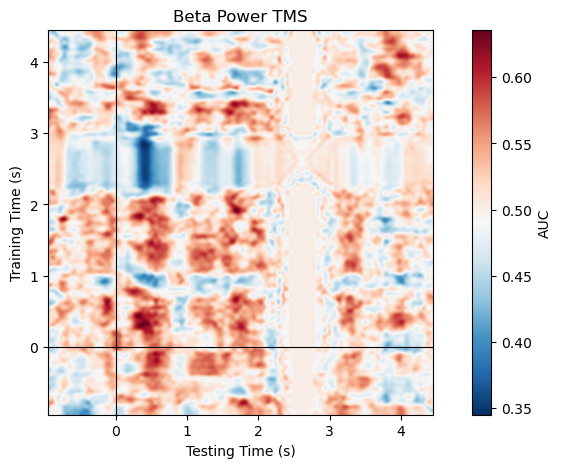

In [26]:
plt.figure(figsize=(10, 5))
plt.imshow(scores_mean,
               interpolation='lanczos', 
               origin='lower', 
               cmap='RdBu_r', 
               extent=[t_down[0], t_down[-1], t_down[0], t_down[-1]],
               )
plt.axvline(0, color='k', lw=0.8)
plt.axhline(0, color='k', lw=0.8)
plt.xlabel('Testing Time (s)')
plt.ylabel('Training Time (s)')
cbar = plt.colorbar()
cbar.set_label('AUC')
plt.title('Beta Power TMS')
plt.show()

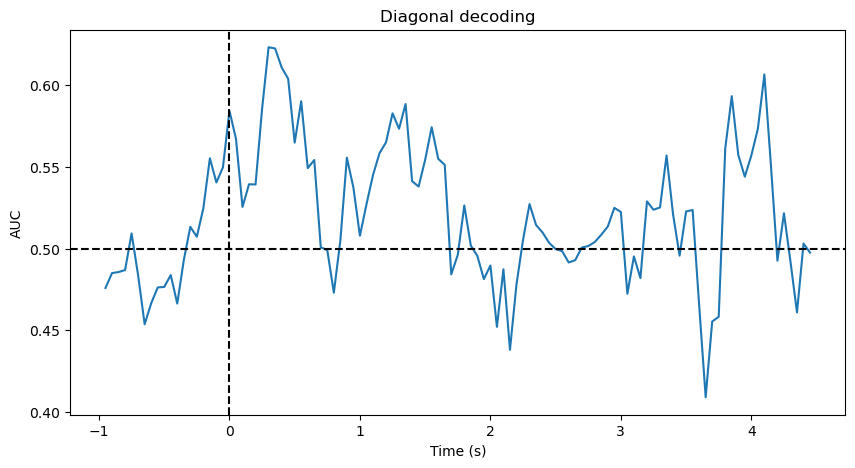

In [27]:
plt.figure(figsize=(10, 5))
plt.plot(t_down, scores_mean.diagonal())
plt.axhline(0.5, color='k', linestyle='--')
plt.axvline(0, color='k', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('AUC')
plt.title('Diagonal decoding')
plt.show()